**@Автор:** Урсол Никита, гр.ИТИНФ-18-2, ХНУРЭ

**Ресурсы:**   
http://www.geom.uiuc.edu/~samuelp/del_project.html  
https://github.com/rexdwyer/DelaunayTriangulation  
https://people.eecs.berkeley.edu/~jrs/274f06/proj.html  

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mc
import matplotlib.animation as anim

In [11]:
np.random.seed(0)
pts = np.random.uniform(size=(100,2))

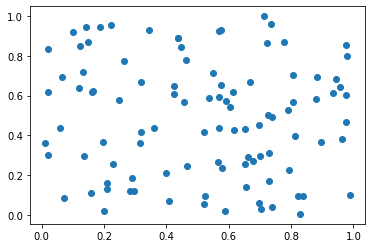

In [12]:
plt.scatter(pts[:,0], pts[:,1])

In [13]:
class Edge:
    def __init__(self, org, dest):
        self.org   = org
        self.dest  = dest
        self.onext = None
        self.oprev = None
        self.sym   = None
        self.data  = None

In [14]:
def prev(coll):
    _, ax = plt.subplots()
    ax.add_collection(coll)
    ax.scatter(pts[:,0], pts[:,1])
    plt.show()

def del_trace():
    global hist
    es = [e for e in edges if e.data is None]
    coll = [(p.org,p.dest) for p in es]
    hist.append(coll)

In [15]:
hist = []
edges = []

def delaunay(Set):   
    global edges
    edges = []

    Set = np.asarray(Set, dtype=np.float64)
    
    Set.view(dtype=[('f0', Set.dtype), ('f1', Set.dtype)]).sort(order=['f0', 'f1'], axis=0)
    
    triangulate(Set)
    edges = [e for e in edges if e.data is None]
    return edges

In [16]:
def triangulate(Set):
    if len(Set) == 2:
        a = make_edge(Set[0], Set[1])
        del_trace()
        return a, a.sym

    elif len(Set) == 3:
        p1, p2, p3 = Set[0], Set[1], Set[2]
        a = make_edge(p1, p2)
        b = make_edge(p2, p3)
        splice(a.sym, b)

        if right_of(p3, a):
            connect(b, a)
            del_trace()
            return a, b.sym
        elif left_of(p3, a):
            c = connect(b, a)
            del_trace()
            return c.sym, c
        else:
            del_trace()
            return a, b.sym

    else:
        m = (len(Set) + 1) // 2
        
        L, R = Set[:m], Set[m:]
        ldo, ldi = triangulate(L)
        rdi, rdo = triangulate(R)
        
        while True:
            if right_of(rdi.org, ldi):
                ldi = ldi.sym.onext
            elif left_of(ldi.org, rdi):
                rdi = rdi.sym.oprev
            else:
                break

        base = connect(ldi.sym, rdi)

        if ldi.org[0] == ldo.org[0] and ldi.org[1] == ldo.org[1]:
            ldo = base
        if rdi.org[0] == rdo.org[0] and rdi.org[1] == rdo.org[1]:
            rdo = base.sym

        while True:
            rcand, lcand = base.sym.onext, base.oprev
            v_rcand, v_lcand = right_of(rcand.dest, base), right_of(lcand.dest, base)
            if not (v_rcand or v_lcand):
                break
            if v_rcand:
                while right_of(rcand.onext.dest, base) and \
                      in_circle(base.dest, base.org, rcand.dest, rcand.onext.dest) == 1:
                    t = rcand.onext
                    delete_edge(rcand)
                    rcand = t
            if v_lcand:
                while right_of(lcand.oprev.dest, base) and \
                      in_circle(base.dest, base.org, lcand.dest, lcand.oprev.dest) == 1:
                    t = lcand.oprev
                    delete_edge(lcand)
                    lcand = t
            if not v_rcand or \
               (v_lcand and in_circle(rcand.dest, rcand.org, lcand.org, lcand.dest) == 1):
                base = connect(lcand, base.sym)
            else:
                base = connect(base.sym, rcand.sym)
                
        del_trace()        
        return ldo, rdo

In [17]:
def in_circle(a, b, c, d):
    a1, a2 = a[0]-d[0], a[1]-d[1]
    b1, b2 = b[0]-d[0], b[1]-d[1]
    c1, c2 = c[0]-d[0], c[1]-d[1]
    a3, b3, c3 = a1**2 + a2**2, b1**2 + b2**2, c1**2 + c2**2
    det = a1*b2*c3 + a2*b3*c1 + a3*b1*c2 - (a3*b2*c1 + a1*b3*c2 + a2*b1*c3)
    return det < 0

def right_of(p, e):
    a, b = e.org, e.dest
    det = (a[0]-p[0]) * (b[1]-p[1]) - (a[1]-p[1]) * (b[0]-p[0])
    return det > 0

def left_of(p, e):
    a, b = e.org, e.dest
    det = (a[0]-p[0]) * (b[1]-p[1]) - (a[1]-p[1]) * (b[0]-p[0])
    return det < 0

def make_edge(org, dest):
    global edges
    e  = Edge(org, dest)
    es = Edge(dest, org)
    e.sym, es.sym = es, e
    e.onext, e.oprev = e, e
    es.onext, es.oprev = es, es
    edges.append(e)
    return e

def splice(a, b):
    a.onext.oprev, b.onext.oprev = b, a
    a.onext, b.onext = b.onext, a.onext

def delete_edge(e):
    splice(e, e.oprev)
    splice(e.sym, e.sym.oprev)
    e.data, e.sym.data = True, True

def connect(a, b):
    e = make_edge(a.dest, b.org)
    splice(e, a.sym.oprev)
    splice(e.sym, b)
    return e

MovieWriter ffmpeg unavailable; using Pillow instead.


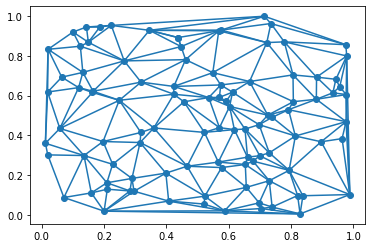

In [18]:
delaunay(pts)

fig, ax = plt.subplots()
ax.scatter(pts[:,0], pts[:,1])
lines = mc.LineCollection([])
ax.add_collection(lines)

def update(frame):
    lines.set_segments(frame)
    return lines,

ani = anim.FuncAnimation(fig, update, frames=[[]]+hist, interval=300)
ani.save('triangulation.gif', dpi=90)